## 1. Library Importing

In [2]:
import nltk # 텍스트 데이터를 처리
import numpy as np # 말뭉치를 배열로 표현
import random
import operator
import string # 표준 파이썬 문자열을 처리
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
import numpy as np
from google.colab import drive

## 2. Data Uploading

In [3]:
  # Colab에서 Google 드라이브를 마운트하기 위한 라이브러리

# 구글 드라이브 마운트
drive.mount('/content/drive')

def loadfile(path):
    X = []
    Y = []

    for label in ('0', '25', '50', '75', '100'):
        print("Loading text files for the label: " + label)

        label_path = os.path.join(path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()

                # 레이블을 숫자로 변환
                if label == '0':
                    Y.append(0)
                elif label == '25':
                    Y.append(1)
                elif label == '50':
                    Y.append(2)
                elif label == '75':
                    Y.append(3)
                elif label == '100':
                    Y.append(4)

                # 텍스트 데이터를 X에 추가
                X.append(text)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_final/'

# loadfile 함수 호출
X, Y = loadfile(directory_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading text files for the label: 0
Loading text files for the label: 25
Loading text files for the label: 50
Loading text files for the label: 75
Loading text files for the label: 100


In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (1577,)
Y shape: (1577,)


In [5]:
def count_txt_files(path):
    file_counts = {}

    for label in ('0', '25', '50', '75', '100'):
        label_path = os.path.join(path, label)
        txt_files = [filename for filename in os.listdir(label_path) if filename.endswith('.txt')]
        file_counts[label] = len(txt_files)

    return file_counts

# .txt 파일 수 확인
file_counts = count_txt_files(directory_path)

# 결과 출력
for label, count in file_counts.items():
    print(f"Number of .txt files in label {label}: {count}")

Number of .txt files in label 0: 365
Number of .txt files in label 25: 300
Number of .txt files in label 50: 305
Number of .txt files in label 75: 303
Number of .txt files in label 100: 304


## 3. 호감도 가중치 증가


In [6]:
# 3-1. 이모지 사용량에 따른 호감도 증가 함수
import re
import numpy as np

# 이모지 카운트 함수
def count_emojis(text):
    emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        ']', flags=re.UNICODE)
    return len(emoji_pattern.findall(text))

# 호감도 라벨링 함수
def label_likeability(text):
    emoji_count = count_emojis(text)
    exclamation_question_count = len(re.findall(r'[!?]', text))
    a_contributions = len(re.findall(r'A:', text))

    # "A"의 발화에 대한 디폴트 호감도 설정
    likeability = 75 if a_contributions > 0 else 0

    # 이모지 사용에 따른 추가적인 호감도 조정
    if emoji_count == 0 and exclamation_question_count == 0:
        likeability = 0
    elif emoji_count == 0 and exclamation_question_count >= 2:
        likeability = 25
    elif emoji_count == 1:
        likeability = 50 if exclamation_question_count >= 2 else 75
    elif emoji_count >= 2:
        likeability = 100

    return likeability

# 예시 텍스트를 사용하여 함수 테스트
example_text = """A: 안녕! 😀
B: 안녕! 😊
A: 오늘 날씨 어때? 🌤️"""
likeability = label_likeability(example_text)
print("호감도 라벨:", likeability)

호감도 라벨: 100


In [7]:
# 3-2. 답장 속도 기반 호감도 예측
from datetime import datetime
import re
import numpy as np
# 대화 데이터를 .txt 파일에서 불러오기
conversation = []
for label in ('0', '25', '50', '75', '100'):
    label_path = os.path.join(directory_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                conversation.extend(file.readlines())


# 호감도 레이블 생성 함수
def create_likeability_labels(conversation):
    response_times = []
    last_message_time = None
    for line in conversation:
        if line.startswith("A:") or line.startswith("B:"):
            # 시간 정보 추출 및 변환
            time_str = re.search(r'\((\d{2}):(\d{2})\)', line)
            if time_str:
                hours, minutes = map(int, time_str.groups())
                current_time = hours * 60 + minutes  # Convert to minutes
                # 답장 속도 계산
                if last_message_time is not None:
                    response_time = current_time - last_message_time
                    response_times.append(response_time)
                last_message_time = current_time
    # 평균 응답 시간 계산 및 호감도 레이블 생성
    avg_response_times = np.mean(response_times) if response_times else 0
    likeability_labels = []
    for response_time in response_times:
        if response_time <= 10:
            likeability = 100
        elif response_time <= 30:
            likeability = 75
        elif response_time <= 60:
            likeability = 50
        elif response_time <= 180:
            likeability = 25
        else:
            likeability = 0
        likeability_labels.append(likeability)
    return likeability_labels
# 대화 데이터를 기반으로 호감도 레이블 생성
likeability_labels = create_likeability_labels(conversation)


## 4.데이터 정제

In [8]:
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import wordnet
import random

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 숫자와 이모지 패턴 정의
    emoji_pattern = re.compile('['
                               u'\U0001F600-\U0001F64F'  # emoticons
                               u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                               ']', flags=re.UNICODE)

    # 불용어 제거 (숫자와 이모지 제외)
    words = text.split()
    filtered_words = [word for word in words if word.isalnum() or emoji_pattern.match(word)]
    return ' '.join(filtered_words)

# 데이터셋에 텍스트 전처리 적용
X_train_preprocessed = [preprocess_text(text) for text in X_train]
X_val_preprocessed = [preprocess_text(text) for text in X_val]

# 토크나이징 및 시퀀싱
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_preprocessed)

# 텍스트를 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train_preprocessed)
X_val_seq = tokenizer.texts_to_sequences(X_val_preprocessed)

# 시퀀스 패딩
max_sequence_length = 100  # 최대 시퀀스 길이 설정
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)



In [15]:
from scipy.stats import mode

# 각 모델의 예측 결과를 저장할 리스트
ensemble_predictions = []

# K-fold 교차 검증 수행
for train_index, val_index in skf.split(X, Y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

    # 데이터 전처리
    X_train_preprocessed = [preprocess_text(text) for text in X_train_fold]
    X_val_preprocessed = [preprocess_text(text) for text in X_val_fold]

    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train_preprocessed)

    X_train_seq = tokenizer.texts_to_sequences(X_train_preprocessed)
    X_val_seq = tokenizer.texts_to_sequences(X_val_preprocessed)

    max_sequence_length = 100
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
    X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)

    # 모델 정의 및 훈련
    model = Sequential()
    model.add(Embedding(10000, 128, input_length=max_sequence_length))
    model.add(LSTM(64))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_padded, y_train_fold, epochs=30, batch_size=8, validation_data=(X_val_padded, y_val_fold), verbose=1)

    # 검증 세트에 대한 예측 수행
    val_predictions = model.predict(X_val_padded)
    val_predictions = np.argmax(val_predictions, axis=-1)

    ensemble_predictions.append(val_predictions)

# 앙상블 모델의 예측 결과 계산 (투표 방식)
ensemble_predictions = np.array(ensemble_predictions)

final_predictions = []
for i in range(ensemble_predictions.shape[1]):
    prediction_column = ensemble_predictions[:, i]
    mode_prediction = mode(prediction_column).mode[0]
    final_predictions.append(mode_prediction)

final_predictions = np.array(final_predictions)

# 최종 정확도 계산
final_accuracy = accuracy_score(Y, final_predictions)
print("Final Accuracy:", final_accuracy)


Epoch 1/30
158/158 [==============================] - 20s 114ms/step - loss: 1.4275 - accuracy: 0.3838 - val_loss: 1.2088 - val_accuracy: 0.5190
Epoch 2/30
158/158 [==============================] - 8s 49ms/step - loss: 0.8151 - accuracy: 0.7066 - val_loss: 0.9859 - val_accuracy: 0.6203
Epoch 3/30
158/158 [==============================] - 4s 23ms/step - loss: 0.4052 - accuracy: 0.8707 - val_loss: 1.0141 - val_accuracy: 0.6361
Epoch 4/30
158/158 [==============================] - 3s 17ms/step - loss: 0.1555 - accuracy: 0.9580 - val_loss: 1.1556 - val_accuracy: 0.6108
Epoch 5/30
158/158 [==============================] - 3s 19ms/step - loss: 0.0666 - accuracy: 0.9857 - val_loss: 1.2814 - val_accuracy: 0.6234
Epoch 6/30
158/158 [==============================] - 4s 25ms/step - loss: 0.0424 - accuracy: 0.9897 - val_loss: 1.2904 - val_accuracy: 0.6392
Epoch 7/30
158/158 [==============================] - 2s 16ms/step - loss: 0.0299 - accuracy: 0.9897 - val_loss: 1.3630 - val_accuracy: 0.62

<ipython-input-15-703f7a0d7185>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ensemble_predictions = np.array(ensemble_predictions)


IndexError: tuple index out of range

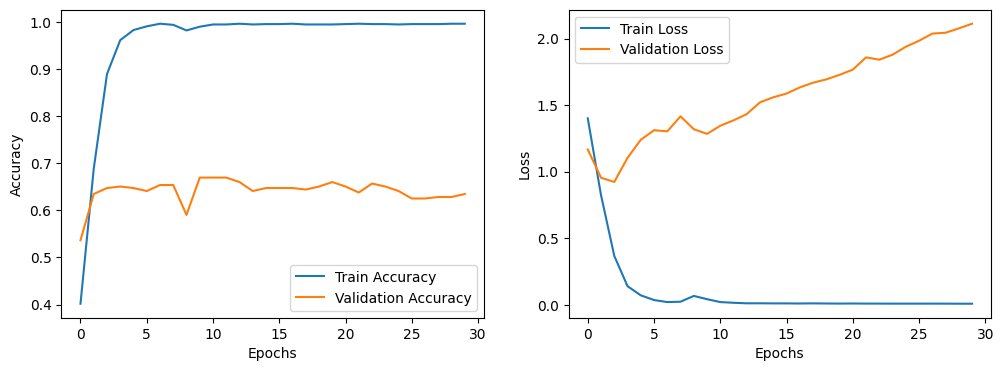

In [16]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실과 정확도 그래프 그리기
plt.figure(figsize=(12, 4))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


10/10 [==============================] - 0s 8ms/step


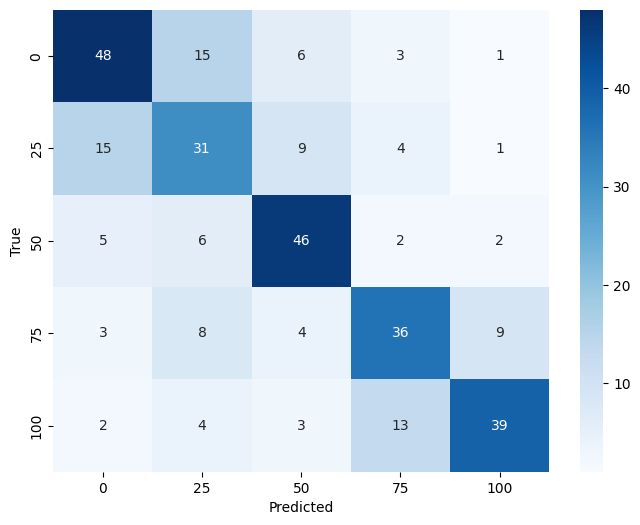

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = [0, 25, 50, 75, 100]

# 검증 데이터에 대한 예측
y_pred = model.predict(X_val_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix 계산
cm = confusion_matrix(y_val_fold, y_pred_classes)

# Confusion Matrix를 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [20]:
from sklearn.metrics import classification_report

# 클래스 레이블 이름을 포함한 문자열 리스트 설정
labels = ['Class0', 'Class25', 'Class50', 'Class75', 'Class100']

# 분류 보고서 출력
print(classification_report(y_val_fold, y_pred_classes, target_names=labels))


              precision    recall  f1-score   support

      Class0       0.66      0.66      0.66        73
     Class25       0.48      0.52      0.50        60
     Class50       0.68      0.75      0.71        61
     Class75       0.62      0.60      0.61        60
    Class100       0.75      0.64      0.69        61

    accuracy                           0.63       315
   macro avg       0.64      0.63      0.63       315
weighted avg       0.64      0.63      0.64       315



In [21]:
import time

# 모델 용량 확인
model.summary()

# 추론 시간 측정
num_samples = len(X_val_padded)
inference_times = []

for i in range(num_samples):
    start_time = time.time()
    sample = X_val_padded[i:i+1]  # 1개의 샘플만 추론
    _ = model.predict(sample)
    end_time = time.time()
    inference_times.append(end_time - start_time)

average_inference_time = sum(inference_times) / len(inference_times)
print(f"Average Inference Time per Sample: {average_inference_time:.4f} seconds")


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1329733 (5.07 MB)
Trainable params: 1329733 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step
Average Inference Time per Sample: 0.0838 seconds
